# Código Clasificación buques mercantes utilizando CNN.
Cristóbal Balmelli

#### Modificaciones Eduardo Carrasco
Descripción Máquina en la que se está corriendo

In [3]:
### Conocer version de paquetes y Hardware en uso
#------------------------------------------------------
#------------------------------------------------------
import sys
import tensorflow.keras
import keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Plataforma (Software-Hardware): {platform.platform()}")
print(f"Versión de Python {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"versión de Pandas {pd.__version__}")
print(f"versión de Numpy {np.__version__}")
print(f"versión de Keras {keras.__version__}")
print(f"Versión de Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU está", "Disponible" if gpu else "No Disponible")
#---------------------------------------------------------

Plataforma (Software-Hardware): macOS-13.5-arm64-arm-64bit
Versión de Python 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
Versión de TensorFlow: 2.13.0
versión de Pandas 2.0.3
versión de Numpy 1.24.3
versión de Keras 2.13.1
Versión de Scikit-Learn 1.3.0
GPU está Disponible


## Cargamos las librerias necesarias

In [6]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.activations import relu
from PIL import Image
import imghdr
from keras.preprocessing.image import ImageDataGenerator

/var/folders/sh/2jnszg1d0llfrs9_1_8prq9r0000gn/T/ipykernel_3962/1248193511.py:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Cargamos las imagenes

In [7]:
dirname = os.path.join(os.getcwd(), 'datos')
imgpath = dirname + os.sep 

altura,longitud=100,100 #tamaño pixeles de las imagenes... OJO CON LA CANTIDAD DE PIXELES

directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        # Verificamos si el archivo es una imagen válida antes de abrirlo
        tipo_imagen = imghdr.what(os.path.join(ruta, archivo))
        if tipo_imagen in ['jpeg', 'png', 'bmp', 'gif']:
            imagen = Image.open(os.path.join(ruta, archivo))
            imagen = imagen.resize((altura, longitud))
            imagen_array = np.array(imagen)
            # Verificamos que la imagen tenga 3 canales (RGB) antes de agregarla
            if len(imagen_array.shape) == 3 and imagen_array.shape[2] == 3:
                imagenes_redimensionadas.append(imagen_array)
    return imagenes_redimensionadas

# Rutas de los directorios de imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y otros
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /Users/educarrascovidal/Documents/GitHub/ClasificadorSAR/datos/
/Users/educarrascovidal/Documents/GitHub/ClasificadorSAR/datos/mercantes 1
/Users/educarrascovidal/Documents/GitHub/ClasificadorSAR/datos/otros 54
Directorios leidos: 2
Imagenes en cada directorio [55, 34]
suma Total de imagenes en subdirs: 89


## Crear etiquetas y clases

**Creamos los labels con valor 1 para mercante y 0 para otros**

In [8]:
# Crear una lista de etiquetas (0 para mercantes, 1 para otros)
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Muestra de Imágenes:

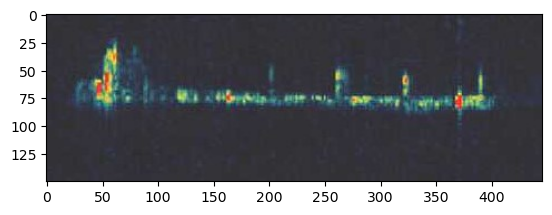

In [9]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/mercantes/10.jpg'))

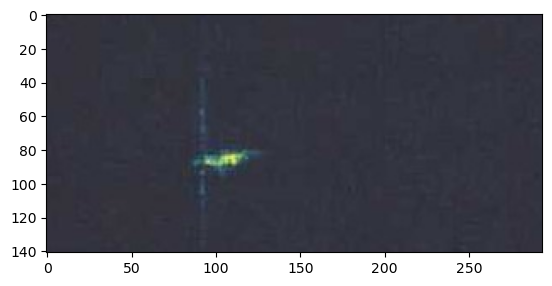

In [10]:
# Muestra de Etiqueta Otros:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('datos/otros/11.jpg'))

## Creamos sets de Entrenamiento y Test

In [11]:
# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=218) #num de cadete

train_X = train_X / 255.
valid_X = valid_X / 255.

# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Data augmentation

In [12]:
# Configurar las transformaciones de data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)

## Creamos la red neuronal

### 1RA PROPUESTA

In [14]:
INIT_LR = 0.0001#1e-3 

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
tamano_filtro1=(5,5)
tamano_filtro2=(3,3)
tamano_pool=(2,2)

modelo = Sequential(name='modelo_edu')
modelo.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo.add(MaxPooling2D(pool_size=tamano_pool))

#tercera capa de convolucion
modelo.add(Convolution2D(filtrosConv3, tamano_filtro2, padding='same', activation='relu'))

#capa que aplana la imagen (1D)
modelo.add(Flatten())

#capa normal, de 256 neuronas
modelo.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo.add(Dropout(0.5))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo.summary()

modelo.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "modelo_edu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 80000)             0

**Cristóbal, Aprender esta tabla que explica como se calcula todo en el modelo anterior:**

| Layer (type) | Param Definition | Input Shape | Output Shape | Param Calculation (Formula and Values) | Param # |
| --- | --- | --- | --- | --- | --- |
| Conv2D | Kernel: (3,3) | (100, 100, 3) | (100, 100, 32) | (altura x ancho x canales_entrada + 1 bias) x filtros = (3x3x3+1) x 32 | 896 |
| MaxPooling2D | Tamaño del Pool: (2,2) | (100, 100, 32) | (50, 50, 32) | 0 (No hay parámetros en las capas de pooling) | 0 |
| Conv2D | Kernel: (2,2) | (50, 50, 32) | (50, 50, 64) | (altura x ancho x canales_entrada + 1 bias) x filtros = (2x2x32+1) x 64 | 8,256 |
| MaxPooling2D | Tamaño del Pool: (2,2) | (50, 50, 64) | (25, 25, 64) | 0 (No hay parámetros en las capas de pooling) | 0 |
| Flatten | N/A | (25, 25, 64) | (40,000) | 0 (No hay parámetros en las capas flatten) | 0 |
| Dense | Unidades: 256 | (40,000) | (256) | (entrada x salida + 1 bias por unidad salida) = (40,000 x 256) + 256 | 10,240,256 |
| Dropout | Rate: 0.5 | (256) | (256) | 0 (No hay parámetros en las capas de dropout) | 0 |
| Dense | Unidades: 2 | (256) | (2) | (entrada x salida + 1 bias por unidad salida) = (256 x 2) + 2 | 514 |

## Entrenamos la red
Con los datos de data augmentation

In [15]:
epochs = 200
batch_size = 32

# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

## Modifica el train_x para incluir las imagenes del train_data_generator
history=modelo.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))
# history=modelo.fit(train_X, train_label_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label_one_hot))

# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
dir='./modelo/'

if not os.path.exists(dir):
    os.mkdir(dir)
modelo.save('./modelo/modelo.h5')
modelo.save_weights('./modelo/pesos.h5')

Epoch 1/200


2023-07-29 18:31:11.514928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 601ms/step - loss: 0.7191 - accuracy: 0.3947 - val_loss: 0.9060 - val_accuracy: 0.5556
Epoch 2/200
2/2 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.5263

2023-07-29 18:31:14.328751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 84ms/step - loss: 0.8051 - accuracy: 0.5263 - val_loss: 0.8080 - val_accuracy: 0.5556
Epoch 3/200
2/2 [==============================] - 0s 71ms/step - loss: 0.7120 - accuracy: 0.6250 - val_loss: 0.7141 - val_accuracy: 0.5556
Epoch 4/200
2/2 [==============================] - 0s 70ms/step - loss: 0.6842 - accuracy: 0.5938 - val_loss: 0.6863 - val_accuracy: 0.5556
Epoch 5/200
2/2 [==============================] - 0s 49ms/step - loss: 0.6680 - accuracy: 0.5526 - val_loss: 0.6792 - val_accuracy: 0.5556
Epoch 6/200
2/2 [==============================] - 0s 50ms/step - loss: 0.7117 - accuracy: 0.5000 - val_loss: 0.6776 - val_accuracy: 0.6667
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 0.6394 - accuracy: 0.7368 - val_loss: 0.6764 - val_accuracy: 0.6667
Epoch 8/200
2/2 [==============================] - 0s 76ms/step - loss: 0.6769 - accuracy: 0.5789 - val_loss: 0.6769 - val_accuracy: 0.5556
Epoch 9/200
2/2 [===============

/Users/educarrascovidal/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Obtenemos las métricas de entrenamiento y validación, luego graficamos

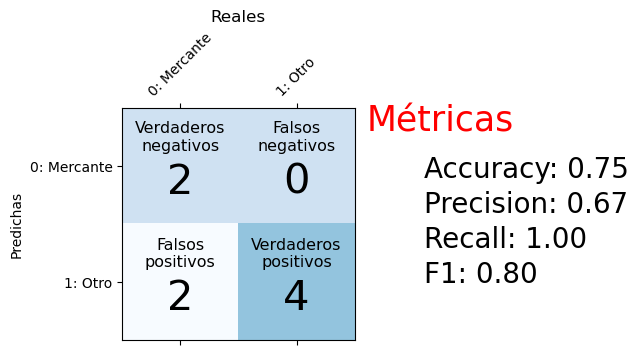

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def metricas(clases_reales, clases_predichas):
    matriz_conf=confusion_matrix(clases_reales, clases_predichas)
    accuracy=accuracy_score(clases_reales,clases_predichas)
    precision=precision_score(clases_reales,clases_predichas)
    recall=recall_score(clases_reales,clases_predichas)
    f1=f1_score(clases_reales,clases_predichas)
    return matriz_conf, accuracy, recall, precision, f1

def visualizar_metricas(clases_reales,clases_predichas, titulo):
    #Calculamos metricas con la funcion previa
    matriz, accuracy, recall, precision, f1=metricas(clases_reales,clases_predichas)

    #Graficamos
    plt.figure(figsize=(3,3))
    matriz=pd.DataFrame(matriz,columns=['0: Mercante', '1: Otro'])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)    
    plt.show()
    print("\n")

print("\n")

reales=[1,1,0,0,0,0,1,1]
predichas=[1,1,0,1,0,1,1,1]

visualizar_metricas(reales,predichas,'Métricas')

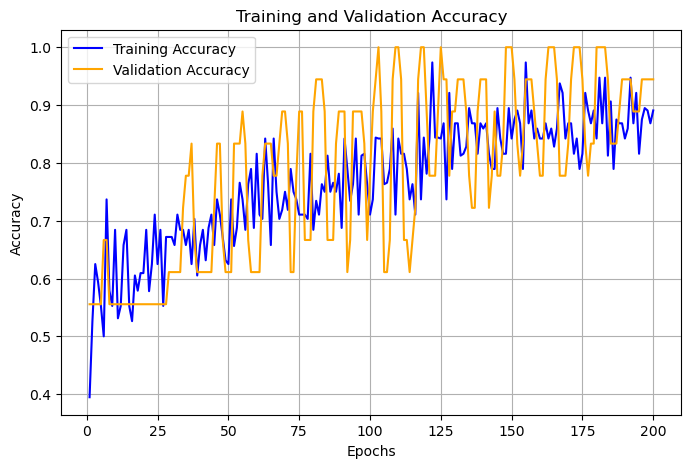

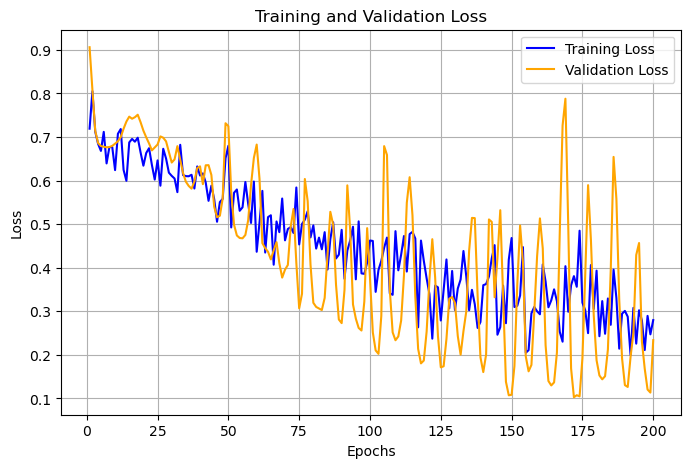

In [17]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Gráfica de precisión (accuracy)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de pérdida (loss)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Probamos la red

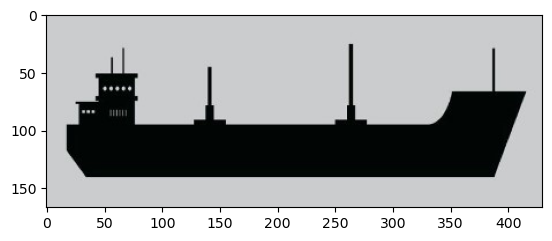

In [18]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('prueba/4.jpg'))

2023-07-29 18:33:04.399777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 431ms/step


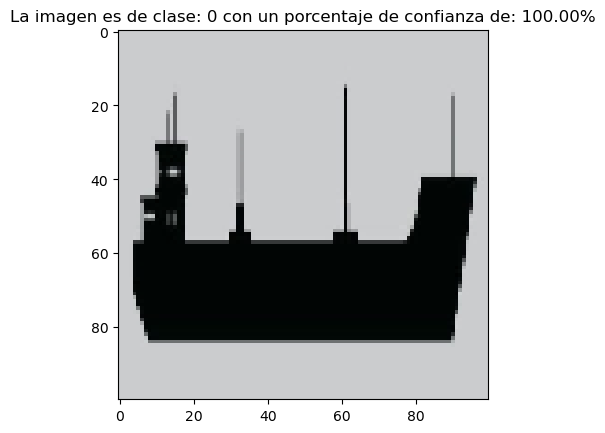

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

directorio_imagen_prueba='./prueba/4.jpg'
# Carga la imagen de prueba
imagen_prueba = cv2.imread(directorio_imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))

# OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

# Convertir a float32 y normalizar
imagen_prueba = imagen_prueba.astype('float32') / 255.0

# Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

# Obtén las predicciones utilizando el modelo entrenado
predicciones = modelo.predict(imagen_prueba)

# Las predicciones son un arreglo de probabilidades, conviértelas a una clase
clase_predicha = np.argmax(predicciones[0])

# Obten la clase correspondiente al índice
clase = classes[clase_predicha]

# Obten el porcentaje de confianza para la clase predicha
porcentaje_confianza = predicciones[0][clase_predicha] * 100

# Carga la imagen de nuevo para mostrarla (esta vez en formato RGB para matplotlib)
imagen_prueba = cv2.cvtColor(cv2.imread(directorio_imagen_prueba), cv2.COLOR_BGR2RGB)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))

plt.imshow(imagen_prueba)
plt.title("La imagen es de clase: {} con un porcentaje de confianza de: {:.2f}%".format(clase, porcentaje_confianza))
plt.show()

In [22]:
def prueba_modelo(modelo, directorio, altura, longitud, classes):
    resultados = []
    for archivo in os.listdir(directorio):
        ruta_imagen = os.path.join(directorio, archivo)
        # Carga la imagen de prueba
        imagen_prueba = cv2.imread(ruta_imagen)
        imagen_prueba = cv2.resize(imagen_prueba, (altura, longitud))

        # OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
        imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

        # Convertir a float32 y normalizar
        imagen_prueba = imagen_prueba.astype('float32') / 255.0

        # Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
        imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

        # Obtén las predicciones utilizando el modelo entrenado
        predicciones = modelo.predict(imagen_prueba)

        # Las predicciones son un arreglo de probabilidades, conviértelas a una clase
        clase_predicha = np.argmax(predicciones[0])

        # Obten la clase correspondiente al índice
        clase = classes[clase_predicha]

        resultados.append((archivo, clase))

    return resultados

# Uso de la función prueba_modelo
directorio_imagenes = './prueba'
resultados = prueba_modelo(modelo, directorio_imagenes, altura, longitud, classes)

# Mostrar resultados
for archivo, clase in resultados:
    print(f"La imagen {archivo} es de clase: {clase}")

1/1 [==============================] - 0s 7ms/step
La imagen 8.jpg es de clase: 0
La imagen 4.jpg es de clase: 0
La imagen 5.jpg es de clase: 0
La imagen 7.jpg es de clase: 0
La imagen 6.jpg es de clase: 0
La imagen 2.png es de clase: 0
La imagen 3.jpg es de clase: 0
La imagen 1.jpg es de clase: 0
